# Trend and Anomaly Analyses of Long-term Spatiotemporal Dataset

**Trend** and **anomaly** analyses are widely used in Earth Science research for detecting long term change.

An example is presented in this notebook of a numerical analysis of Sea Surface Temperature (SST) where the global change rate per decade has been calculated from 1982 to 2016. Moreover, its area-weighted global monthly SST anomaly time series is presented, too.

* Data Source
> NOAA Optimum Interpolation (OI) Sea Surface Temperature (SST) V2 is downloaded from https://www.esrl.noaa.gov/psd/data/gridded/data.noaa.oisst.v2.html

## 1. Load basic libs

In [1]:
import importlib
import pandas as pd
import xarray as xr
import numpy as np
from numpy import nan
import sys
import warnings
import math
from glob import glob
import matplotlib.pyplot as plt

## 2. Read SST data

In [2]:
ds = xr.open_dataset('../data/sst.mnmean.nc', drop_variables=['time_bnds'])
ds = ds.sel(time=slice('1982', '2016'))
ds

<xarray.Dataset> Size: 27MB
Dimensions:  (lat: 89, lon: 180, time: 420)
Coordinates:
  * lat      (lat) float32 356B 88.0 86.0 84.0 82.0 ... -82.0 -84.0 -86.0 -88.0
  * lon      (lon) float32 720B 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
  * time     (time) datetime64[ns] 3kB 1982-01-01 1982-02-01 ... 2016-12-01
Data variables:
    sst      (time, lat, lon) float32 27MB ...
Attributes: (12/37)
    climatology:               Climatology is based on 1971-2000 SST, Xue, Y....
    description:               In situ data: ICOADS2.5 before 2007 and NCEP i...
    keywords_vocabulary:       NASA Global Change Master Directory (GCMD) Sci...
    keywords:                  Earth Science > Oceans > Ocean Temperature > S...
    instrument:                Conventional thermometers
    source_comment:            SSTs were observed by conventional thermometer...
    ...                        ...
    creator_url_original:      https://www.ncei.noaa.gov
    license:                   No constraints on data access or use
    comment:                   SSTs were observed by conventional thermometer...
    summary:                   ERSST.v5 is developed based on v4 after revisi...
    dataset_title:             NOAA Extended Reconstructed SST V5
    data_modified:             2024-08-05

In [6]:
lons = ds.lon
lats = ds.lat
sst = ds.sst
nctime = ds.time

nt, nlat, nlon = sst.shape
ngrd = nlon*nlat

## 3. Trend Analysis

Here we present two ways of calculating linear trend. 

The first method is by using function `np.polyfit` ['https://numpy.org/doc/stable/reference/generated/numpy.polyfit.html']. The basic syntax is `p = np.polyfit(x,y,deg)` with `deg = 1` for linear regression.

The second method is by using function 
`stats.linregress` ['https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.linregress.html']. The basic syntax is `slope, intercept, r, p, se = stats.linregress(x, y)`.

### 3.1a Linear trend calculation with `np.polyfit`

In [22]:
# first set up x and y
# for y, reshape sst to a matrix of nt-by-ngrd

sst_grd  = sst.values.reshape((nt, ngrd)) 
x        = np.linspace(1,nt,nt)
sst_trend1 = np.empty((ngrd,1))
sst_trend1[:,:] = np.nan

In [23]:
for i in range(ngrd): 
    y = sst_grd[:,i]   
    if (not np.isnan(y[0])):  # calculation is only done over the ocean grids, not land grids (nan)
        z = np.polyfit(x, y, 1) 
        sst_trend1[i,0] = z[0]*120.0  
        # the unit for z[0] is degC per month, multiply by 120 to get a unit of degC per decade

sst_trend1 = sst_trend1.reshape((nlat,nlon))

### 3.1b Linear trend calculation with `stats.linregress`

In [24]:
import scipy.stats as stats

sst_grd  = sst.values.reshape((nt, ngrd)) 
x        = np.linspace(1,nt,nt)
sst_trend2 = np.empty((ngrd,1))
sst_trend2[:,:] = np.nan

In [25]:
for i in range(ngrd): 
    y = sst_grd[:,i]   
    if (not np.isnan(y[0])): 
        slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
        sst_trend2[i,0] = slope*120.0     
    
sst_trend2 = sst_trend2.reshape((nlat,nlon))

### 3.2 Visualize SST trend

In [14]:
# clevs = np.linspace(-0.75, 0.75, 21)
# clevs

array([-0.75 , -0.675, -0.6  , -0.525, -0.45 , -0.375, -0.3  , -0.225,
       -0.15 , -0.075,  0.   ,  0.075,  0.15 ,  0.225,  0.3  ,  0.375,
        0.45 ,  0.525,  0.6  ,  0.675,  0.75 ])

Text(0, 0.5, '$^oC$/decade')

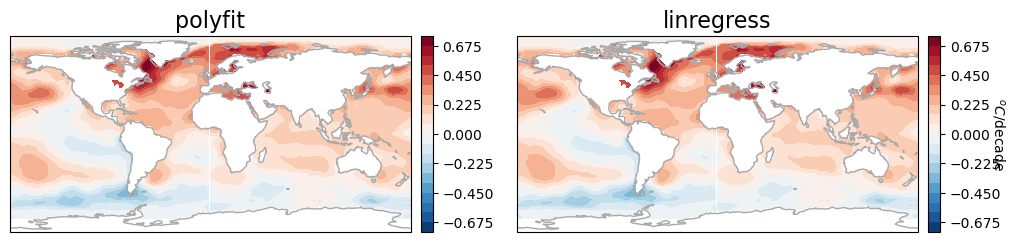

In [36]:
import matplotlib.pyplot as plt; import matplotlib
import cartopy.crs as ccrs
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
import datetime as dt

fig, axes = plt.subplots(ncols=2, 
                         subplot_kw={'projection': ccrs.PlateCarree()},
                         figsize=(12,9))
ax0, ax1 = axes

clevs = np.linspace(-0.75, 0.75, 21)
cs = ax0.contourf(lons, lats, sst_trend1, clevs, cmap=plt.cm.RdBu_r)
ax0.coastlines(color='darkgray', linewidth=1)
ax0.set_title('polyfit', fontsize=16)
cax = make_axes_locatable(ax0).append_axes("right", size="3%", pad=0.1, axes_class=plt.Axes)
cbar = plt.colorbar(cs, cax=cax, orientation='vertical') 

cs = ax1.contourf(lons, lats, sst_trend2, clevs, cmap=plt.cm.RdBu_r)
ax1.coastlines(color='darkgray', linewidth=1)
ax1.set_title('linregress', fontsize=16)
cax = make_axes_locatable(ax1).append_axes("right", size="3%", pad=0.1, axes_class=plt.Axes)
cbar = plt.colorbar(cs, cax=cax, orientation='vertical')
cbar.ax.set_ylabel('$^oC$/decade', rotation=270)